In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU,Activation,Dropout,Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model


In [2]:
# pre-set the plot font sizes...

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [3]:
df = pd.read_excel(r"C:\Users\HP\Desktop\NIFTY_50.xlsx")

In [4]:
# dataframe dimensions
df.shape

(4154, 7)

In [5]:
# column data types
df.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
ltp       float64
volume      int64
dtype: object

In [6]:
# display top 10 observations of the dataset
df.head(10)

,date,open,high,low,close,ltp,volume
0,2001-06-01,1168.099976,1175.800049,1146.900024,1148.050049,1148.050049,119800256
1,2001-06-04,1148.000000,1154.449951,1125.349976,1127.199951,1127.199951,94629112
2,2001-06-05,1127.150024,1130.650024,1106.800049,1115.599976,1115.599976,115483168
3,2001-06-06,1117.500000,1132.949951,1114.000000,1115.699951,1115.699951,91302832
4,2001-06-07,1115.050049,1116.099976,1095.449951,1112.349976,1112.349976,107671288
5,2001-06-08,1112.449951,1128.900024,1112.449951,1126.599976,1126.599976,106103584
6,2001-06-11,1126.550049,1134.800049,1122.349976,1131.099976,1131.099976,81690952
7,2001-06-12,1131.050049,1133.300049,1121.800049,1127.150024,1127.150024,96815080
8,2001-06-13,1127.099976,1132.949951,1126.900024,1129.000000,1129.000000,93428240
9,2001-06-14,1128.949951,1128.949951,1110.150024,1112.750000,1112.750000,99996072


In [7]:
# sumarize numerical features
df.describe()

,open,high,low,close,ltp,volume
count,4154.000000,4154.000000,4154.000000,4154.000000,4154.000000,4.154000e+03
mean,4772.439828,4806.325905,4733.888913,4770.947702,4770.947702,6.151891e+08
std,2647.984292,2654.882230,2635.534000,2645.007324,2645.007324,3.708036e+08
min,853.000000,877.000000,849.950012,854.200012,854.200012,3.567121e+06
25%,2223.162476,2236.500061,2211.325012,2228.774963,2228.774963,3.126519e+08
50%,4979.399902,5029.849854,4931.974854,4977.824951,4977.824951,5.771260e+08
75%,6179.737671,6218.700195,6144.737549,6177.037598,6177.037598,8.322671e+08
max,11120.849609,11171.549805,11075.950195,11130.400391,11130.400391,2.137053e+09


In [8]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M:%S')
# sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

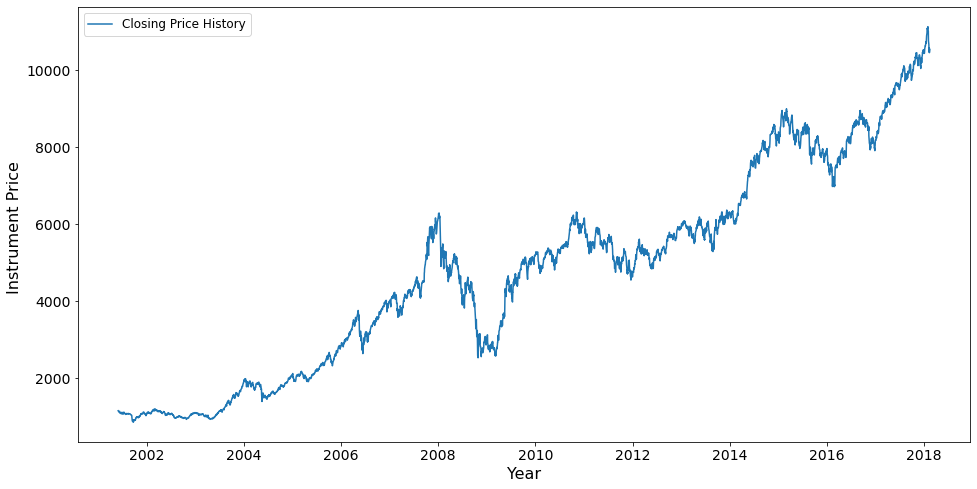

In [9]:
plt.figure(figsize = (16,8))
plt.plot(df['date'], df['close'], label = 'Closing Price History')
plt.legend(loc = "upper left")
plt.xlabel('Year')
plt.ylabel('Instrument Price ')
#plt.show()
plt.savefig(r'C:\Users\HP\Desktop\project\raw data.png')

In [10]:

test_size = 0.2
training_size = 1 - test_size


train_num = int(training_size * len(df))
test_num = len(df) - train_num

print("train_num: " + str(train_num))
print("test_num: " + str(test_num))

train_num: 3323
test_num: 831


In [48]:
train = df[:train_num][['date', 'close']]
test = df[train_num:][['date', 'close']]

In [11]:

type_of_data = "MULTI VARIATE"   # UNI VARIATE   OR MULTI VARIATE
if type_of_data == "UNI VARIATE" :
    colNames = ["close"]
elif type_of_data == "MULTI VARIATE" :
    colNames = ["open","high","low","close","volume"]

data_set = df[colNames]
scaled_data = data_set.copy()

In [34]:
# scale our dataset
look_back_period = 60
days = 0

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data[colNames] = scaler.fit_transform(data_set[colNames])
scaled_data_train = scaled_data[:train_num]
scaled_data_test = scaled_data[train_num - look_back_period - days + 1:]

In [35]:
scaled_data_test = scaled_data_test.reset_index()
scaled_data_test.drop(['index'], axis=1,inplace = True)

In [36]:
scaled_data_test

,open,high,low,close,volume
0,0.670184,0.668087,0.670531,0.667620,0.512800
1,0.668602,0.668412,0.666082,0.671201,0.465416
2,0.674669,0.671715,0.675254,0.674661,0.460186
3,0.676972,0.673351,0.659686,0.658707,0.572172
4,0.660796,0.657931,0.655359,0.654989,0.555845
...,...,...,...,...,...
885,0.919584,0.943912,0.921802,0.938484,0.875246
886,0.949975,0.945840,0.938436,0.936387,0.718861
887,0.941336,0.948152,0.941678,0.946133,0.741154
888,0.931402,0.932843,0.933723,0.934270,0.736823


In [37]:
def get_mape(y_true, y_pred): 
    """
    Compute Mean Absolute Percentage Error (MAPE)
    
    INPUT:
    y_true - actual variable
    y_pred - predicted variable
    
    OUTPUT:
    mape - Mean Absolute Percentage Error (%)
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mape

def get_rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE)
    
    INPUT:
    y_true - actual variable
    y_pred - predicted variable
    
    OUTPUT:
    rmse - Root Mean Squared Error
    
    """
    rmse = np.sqrt(np.mean(np.power((y_true - y_pred),2)))
                   
    return rmse

In [38]:

# create a useful function to split our data into X and y

def x_y(data, N , days = 0):
    """
    Split data into input variable (X) and output variable (y)
    
    INPUT:
    data - dataset to be splitted
    N - time frame to be used
    offset - position to start the split
    
    OUTPUT:
    X - input variable
    y - output variable
    """
    X, y = [], []
    
    for i in range(N + days - 1, len(data)):
        X.append(data[i - N - days + 1 :i - days + 1].to_numpy())
        y.append(data.close[i])
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [39]:
# we use past 60 days stock prices for our training to predict 61th day's closing price.
X_train, y_train = x_y(scaled_data_train, look_back_period, days)
X_test, y_test = x_y(scaled_data_test, look_back_period, days)

In [40]:
def lstm_model(hidden_units=64,layers=1,dense_layers=64,sequence=False):

    model = Sequential()
    for i in range(layers):
    

        if i == 0: model.add(LSTM(units = hidden_units,activation = 'relu',input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = sequence))
        elif i < layers-1: model.add(LSTM(units = hidden_units,activation = 'relu',return_sequences = sequence))
        else: model.add(LSTM(units = hidden_units,activation = 'relu'))

        
        
    model.add(Dense(dense_layers,'relu'))
    model.add(Dense(1,'linear'))
    model.summary()
    return model


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 22,145
Trainable params: 22,145
Non-trainable params: 0
_________________________________________________________________


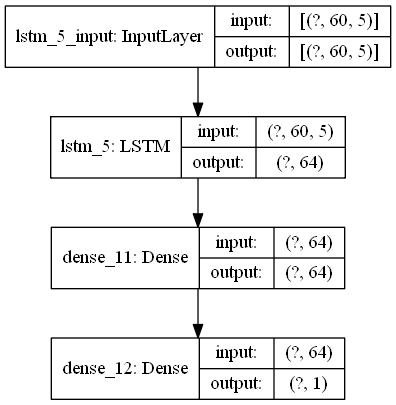

In [57]:
model1 = lstm_model()
plot_model(model1 , to_file='model_plot.png' , show_shapes=True, show_layer_names=True)

In [45]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [51]:
opt = Adam(learning_rate = 0.001)
model1.compile(loss= 'mean_squared_error',metrics=['mean_absolute_error'],optimizer = opt)



#history = model.fit(args[0],epochs = self.epochs,validation_data=args[1])
history = model1.fit(X_train, y_train,batch_size=64,epochs = 10)
print()
#loss, metric = model1.evaluate(X_test)
pred_y = model1.predict(X_test)
closing_price = invTransform ( scaler , pred_y , "close" , colNames )
#print('validation mean absolute error = ',metric)

Enter 1 if MLP else 0     :       0
This is not a MLP model
Epoch 1/10
51/51 [==============================] - 1s 18ms/step - loss: 1.9684e-04 - mean_absolute_error: 0.0097
Epoch 2/10
51/51 [==============================] - 1s 18ms/step - loss: 5.5422e-05 - mean_absolute_error: 0.0052
Epoch 3/10
51/51 [==============================] - 1s 21ms/step - loss: 5.2833e-05 - mean_absolute_error: 0.0050: 0s - loss: 5.7715e-05 - mean_absolute_
Epoch 4/10
51/51 [==============================] - 1s 25ms/step - loss: 4.8672e-05 - mean_absolute_error: 0.0048
Epoch 5/10
51/51 [==============================] - 1s 21ms/step - loss: 4.9650e-05 - mean_absolute_error: 0.0049
Epoch 6/10
51/51 [==============================] - 1s 21ms/step - loss: 4.7476e-05 - mean_absolute_error: 0.0048
Epoch 7/10
51/51 [==============================] - 1s 22ms/step - loss: 4.4175e-05 - mean_absolute_error: 0.0045
Epoch 8/10
51/51 [==============================] - 1s 22ms/step - loss: 4.9299e-05 - mean_absolute_er

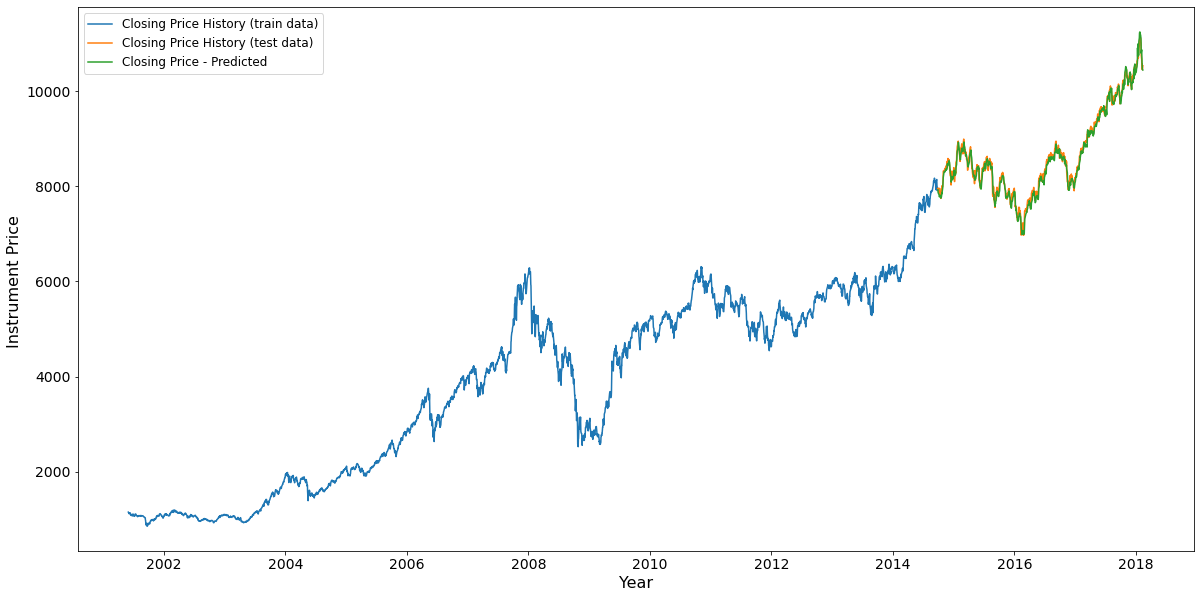

In [53]:
# Plot predicted price vs actual closing price 
def make_plot(train,test,closing_price) :
    test['Predictions_lstm'] = closing_price
    plt.figure(figsize = (20,10))
    plt.xlabel('Year')
    plt.ylabel('Instrument Price ')
    plt.plot(train['date'], train['close'], label = 'Closing Price History (train data)')
    plt.plot(test['date'], test['close'], label = 'Closing Price History (test data)')
    plt.plot(test['date'], test['Predictions_lstm'], label = 'Closing Price - Predicted')
    plt.legend(loc = "upper left")
    plt.show()
    #plt.savefig(r'C:\Users\HP\Desktop\Final pro\{}_batch size {}_epoch  {}_optimizer {}_test size result.png'.format(batch_size,epochs,optimizer,test_size))


make_plot(train,test,closing_price)

In [54]:
# Evaluate performance
rmse_lstm = get_rmse(np.array(test['close']), np.array(test['Predictions_lstm']))
mape_lstm = get_mape(np.array(test['close']), np.array(test['Predictions_lstm']))
print()
print()
print('Root Mean Squared Error: ' + str(rmse_lstm))
print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))



Root Mean Squared Error: 89.52613449692485
Mean Absolute Percentage Error (%): 0.8512561664110848
